## Importando bibliotecas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

## 01 Prevendo valores futuros

In [4]:

dados_f1 = pd.read_csv('../data/Temperatura_mensal_F1.csv')
dados_f1

,DATA,TEMP
0,1963-05-01,23.11
1,1963-06-01,24.20
2,1963-07-01,25.37
3,1963-08-01,23.86
4,1963-09-01,23.03
...,...,...
727,2023-12-01,19.49
728,2024-01-01,19.28
729,2024-02-01,19.73
730,2024-03-01,20.44


In [5]:
# verificar os tipos dos dados
dados_f1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATA    732 non-null    object 
 1   TEMP    732 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.6+ KB


In [6]:
# vamos converter para data 
dados_f1['DATA'] = pd.to_datetime(dados_f1['DATA'], format='%Y-%m-%d')
dados_f1.set_index(['DATA'], inplace=True, drop=True)
dados_f1

,TEMP
DATA,
1963-05-01,23.11
1963-06-01,24.20
1963-07-01,25.37
1963-08-01,23.86
1963-09-01,23.03
...,...
2023-12-01,19.49
2024-01-01,19.28
2024-02-01,19.73


<Axes: xlabel='DATA'>

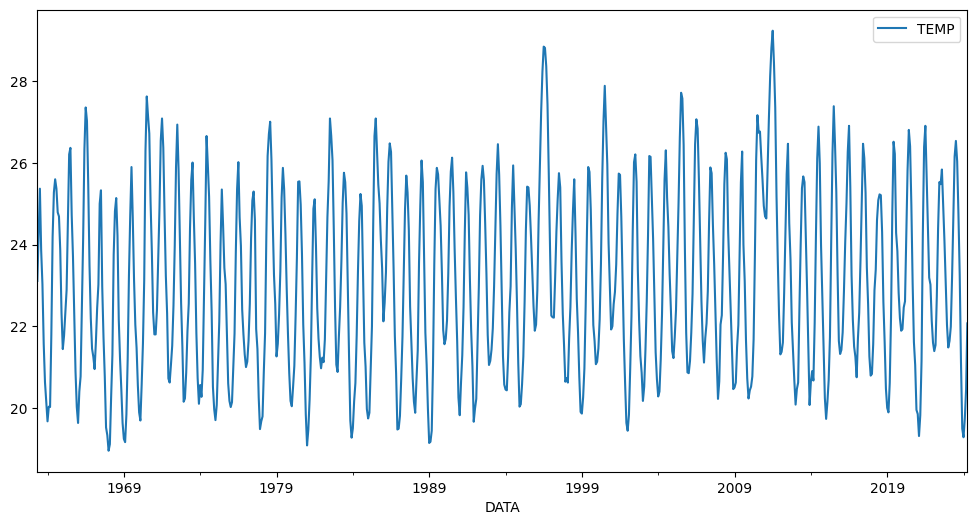

In [7]:
dados_f1.plot(figsize=(12,6))

In [8]:
# Utilizar o modelo naive, é um dos metodos de previsão mais simples, baseando-se na suposição de que o melhor
# preditor para qualquer ponto futuro é o valor mais recente disponivel na serie. Isso significa que a previsão para todos os ponto fututros será
# igual ao ultimo valor obseervado 

dados_f1.shift(1)

# como nosso objetivo é fazer uma previsao  com dados para 3 anos de oscilação de temperaruta Naives não é adequado pois no plot ele fica uma linha reta, para isso vamos de modelos matematicos

,TEMP
DATA,
1963-05-01,NaN
1963-06-01,23.11
1963-07-01,24.20
1963-08-01,25.37
1963-09-01,23.86
...,...
2023-12-01,21.11
2024-01-01,19.49
2024-02-01,19.28


In [9]:
# Avaliando a estacionariedade
from statsmodels.tsa.stattools import adfuller, kpss

def estac(dados):
    
    adf = adfuller(dados)
    print(f'Valor-p do teste ADF: {adf[1]:.4f}')
    if adf[1] > 0.05:
        print('Não rejeitar a Hipótese nula: a série não é estacionaria\n')
    else:
        print('rejeitar a Hipótese nula: a série é estacionaria\n')

    kpss_saida = kpss(dados)
    print(f'Valor-p do teste KPSS: {kpss_saida[1]:.4f}')
    if kpss_saida[1] > 0.05:
        print('Não rejeitar a Hipótese nula: a série é estacionaria\n')
    else:
        print('rejeitar a Hipótese nula: a série não é estacionaria\n')

In [10]:
estac(dados_f1)
# com a comprovação da serie ser estacionaria vamos aplicar um modelo AR

Valor-p do teste ADF: 0.0000
rejeitar a Hipótese nula: a série é estacionaria

Valor-p do teste KPSS: 0.0798
Não rejeitar a Hipótese nula: a série é estacionaria



In [11]:
# Divisão Treino/teste

divisao = int(len(dados_f1)*0.70)

treino = dados_f1.iloc[:divisao].asfreq('MS')
teste = dados_f1.iloc[divisao:].asfreq('MS')

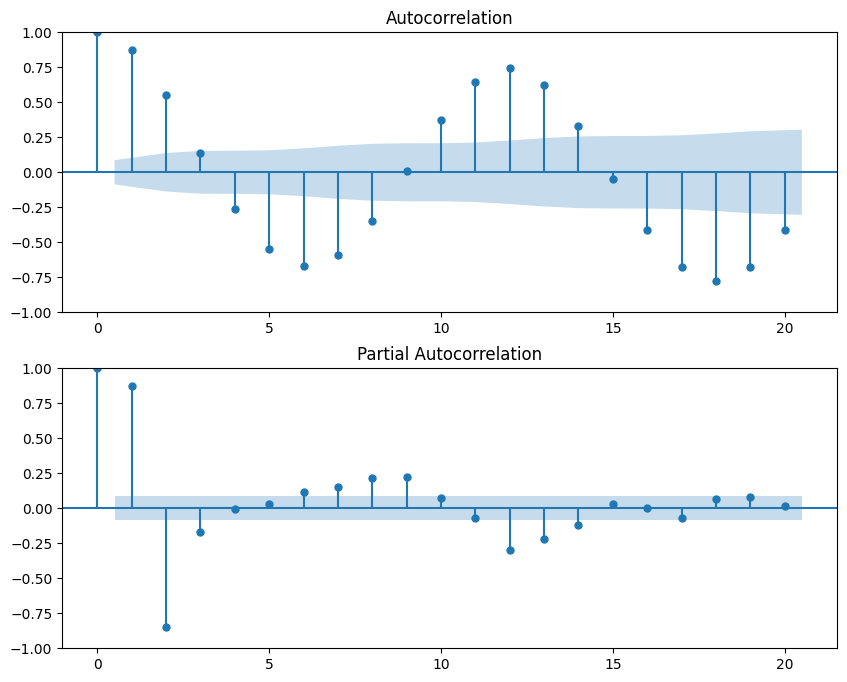

In [12]:
# Construir um modelo AR (Autoregressivo)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=20, ax=ax2)

In [13]:
from statsmodels.tsa.ar_model import AutoReg

ar_mod = AutoReg(treino, 14, old_names=False)
ar_res = ar_mod.fit()
print(ar_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(14)   Log Likelihood                -317.490
Method:               Conditional MLE   S.D. of innovations              0.458
Date:                Fri, 12 Dec 2025   AIC                            666.981
Time:                        06:55:01   BIC                            734.350
Sample:                    07-01-1964   HQIC                           693.421
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0973      0.649      7.855      0.000       3.825       6.369
TEMP.L1        1.1971      0.044     27.078      0.000       1.110       1.284
TEMP.L2       -0.3092      0.069     -4.470      0.0

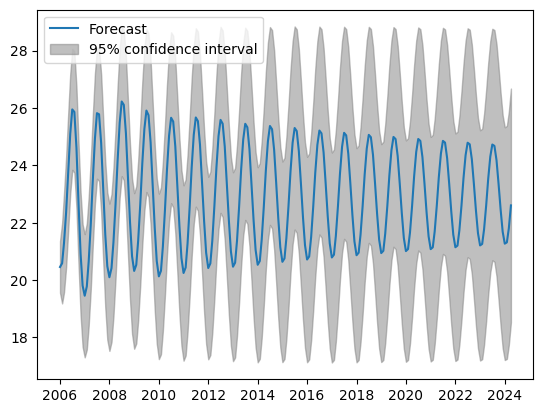

In [14]:
# previsao com autoreg
from statsmodels.tsa.ar_model import AutoRegResults

mod_result = AutoRegResults(ar_mod, ar_res.params, ar_res.cov_params())

fig = mod_result.plot_predict(len(treino), len(treino)+len(teste)-1)

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_prev(treino, teste, mod, nome_mod = ''):

  previsoes = mod.predict(len(treino), len(treino) + len(teste)-1, dynamic=False)

  plt.figure(figsize=(12, 5))

  plt.plot(teste.index, teste, label='Esperado')
  plt.plot(previsoes.index, previsoes, label='Previsto', color='red')

  plt.title(f'Previsão modelo {nome_mod}')
  plt.ylabel('Temperatura')
  plt.legend()
  plt.show()

  print('\nMétricas:\n')
  mae = mean_absolute_error(teste, previsoes)
  print(f'MAE: {mae}')

  mse = mean_squared_error(teste, previsoes)
  print(f'MSE: {mse}')

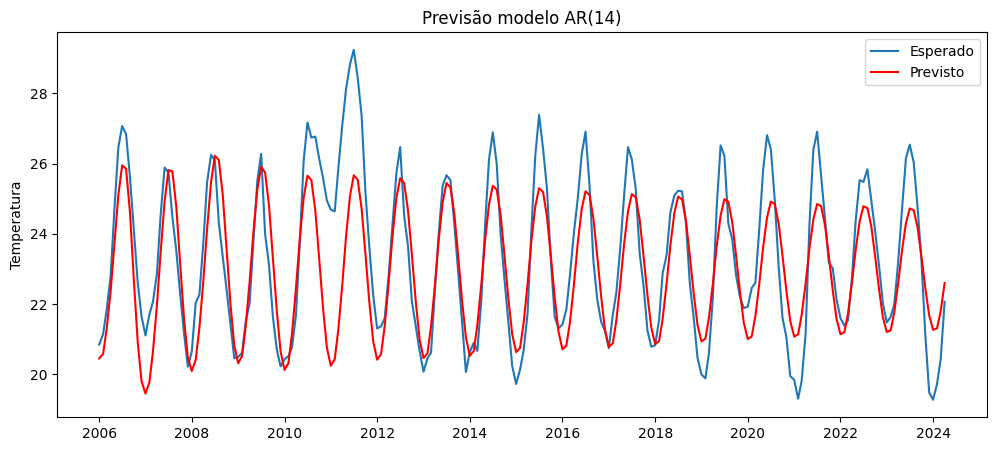


Métricas:

MAE: 1.0427063983973868
MSE: 1.8489038142171543


In [16]:
plot_prev(treino,teste, ar_res, 'AR(14)')

In [17]:
# Melhorando parametros

from statsmodels.tsa.ar_model import ar_select_order
ar_selecao = ar_select_order(treino, 35, old_names=False, ic='aic')

In [18]:
ar_selecao.ar_lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

In [19]:
ar_sel_res = ar_selecao.model.fit()
print(ar_sel_res.summary())

# AIC menor que o ultimo modelo, aparentemente temos uma melhora na escolha de outro parametro

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(34)   Log Likelihood                -265.842
Method:               Conditional MLE   S.D. of innovations              0.422
Date:                Fri, 12 Dec 2025   AIC                            603.684
Time:                        06:55:03   BIC                            753.790
Sample:                    03-01-1966   HQIC                           662.698
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4648      1.091      4.092      0.000       2.326       6.603
TEMP.L1        1.1355      0.045     25.067      0.000       1.047       1.224
TEMP.L2       -0.2017      0.068     -2.958      0.0

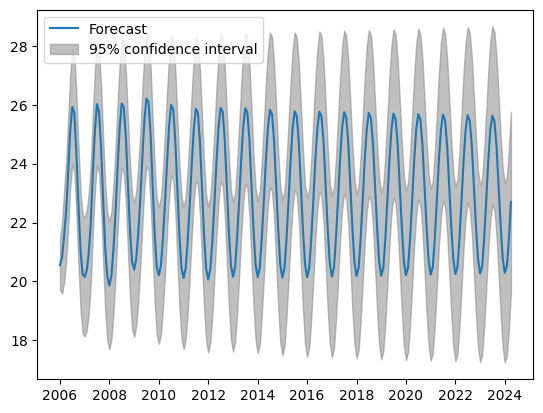

In [20]:
fig = ar_sel_res.plot_predict(len(treino), len(treino) + len(teste) -1)

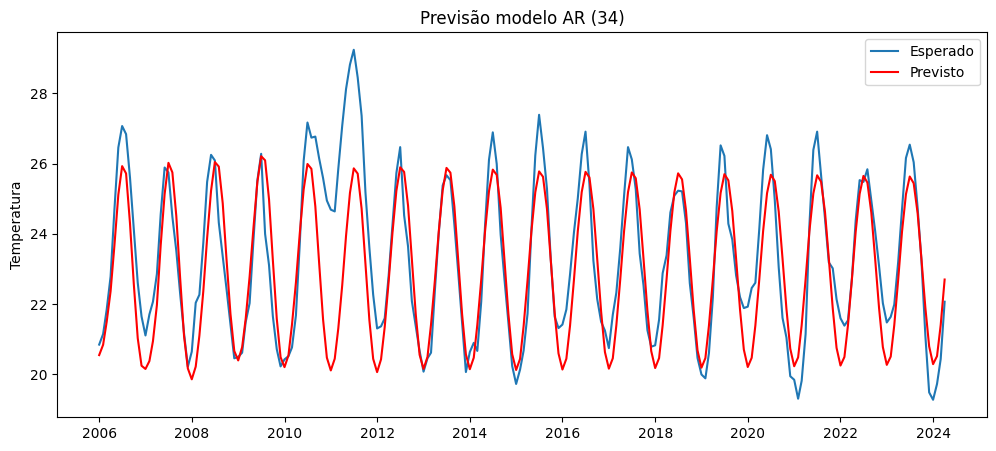


Métricas:

MAE: 0.9474776896250366
MSE: 1.6610673113369703


In [21]:
plot_prev(treino, teste, ar_sel_res, 'AR (34)')

## 02. Componente de média movél

In [22]:
df_f2 = pd.read_csv('../data/Temperatura_mensal_F2.csv')
df_f2

,DATA,TEMP
0,1966-02-01,23.436171
1,1966-03-01,29.787675
2,1966-04-01,25.626345
3,1966-05-01,22.958315
4,1966-06-01,19.513770
...,...,...
694,2023-12-01,15.033869
695,2024-01-01,17.323596
696,2024-02-01,22.818941
697,2024-03-01,29.429283


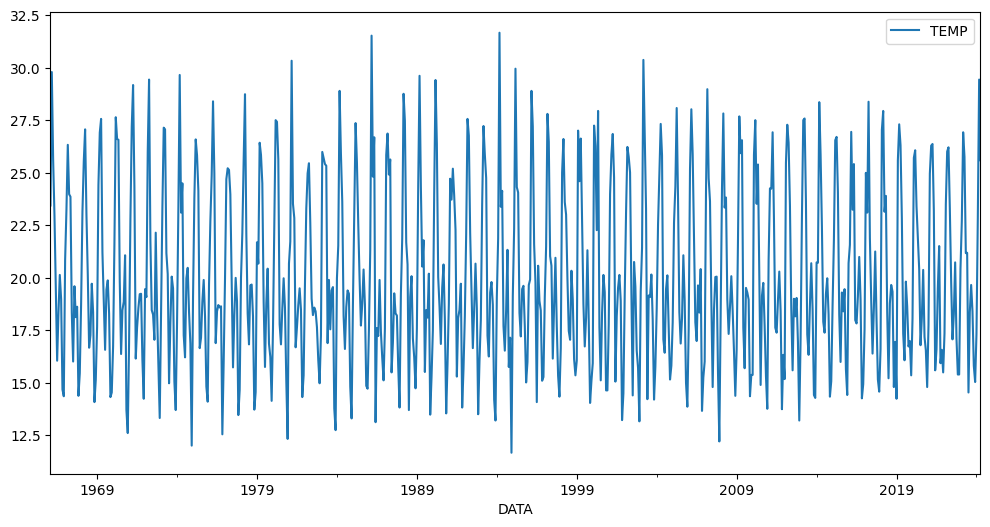

In [23]:
df_f2['DATA'] = pd.to_datetime(df_f2['DATA'], format='%Y-%m-%d')
df_f2.set_index(['DATA'], inplace=True, drop=True)
fig = df_f2.plot(figsize=(12,6))

In [24]:
# verificar estacionariedade
estac(df_f2)

Valor-p do teste ADF: 0.0000
rejeitar a Hipótese nula: a série é estacionaria

Valor-p do teste KPSS: 0.1000
Não rejeitar a Hipótese nula: a série é estacionaria



C:\Users\init\AppData\Local\Temp\ipykernel_12096\607241397.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_saida = kpss(dados)


In [25]:
# Separando para treino e teste

divisao = int(len(df_f2)*0.8)

treino = df_f2.iloc[:divisao].asfreq('MS')
teste = df_f2.iloc[divisao:].asfreq('MS')

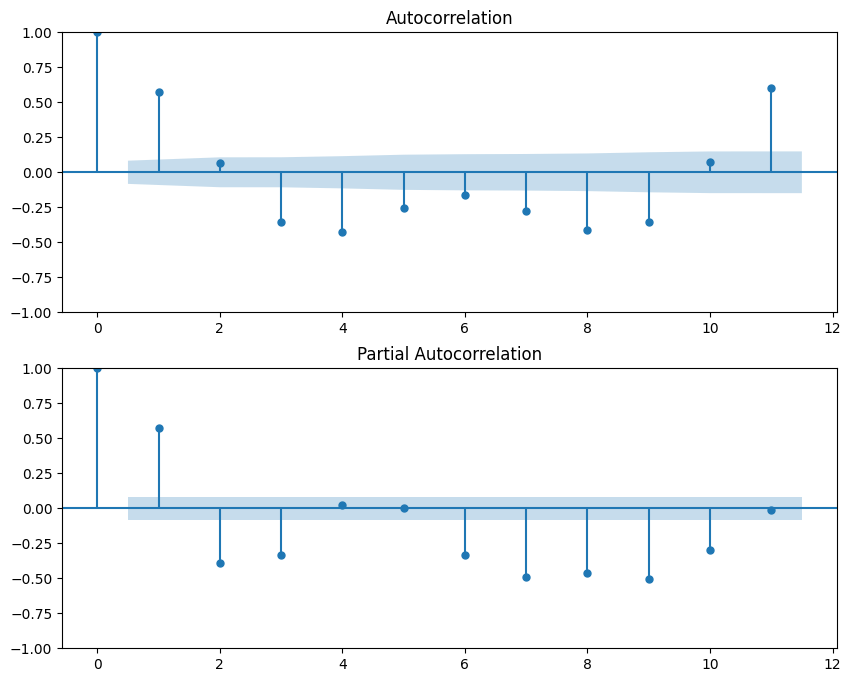

In [26]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=11, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=11, ax=ax2)

In [27]:
ar_mod_f2 = AutoReg(treino, lags=10, old_names=False).fit()
print(ar_mod_f2.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                    AutoReg(10)   Log Likelihood                -993.284
Method:               Conditional MLE   S.D. of innovations              1.477
Date:                Fri, 12 Dec 2025   AIC                           2010.569
Time:                        06:55:05   BIC                           2062.266
Sample:                    12-01-1966   HQIC                          2030.773
                         - 08-01-2012                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.9748      3.244     34.518      0.000     105.617     118.333
TEMP.L1       -0.3349      0.037     -9.170      0.000      -0.406      -0.263
TEMP.L2       -0.3242      0.030    -10.926      0.0

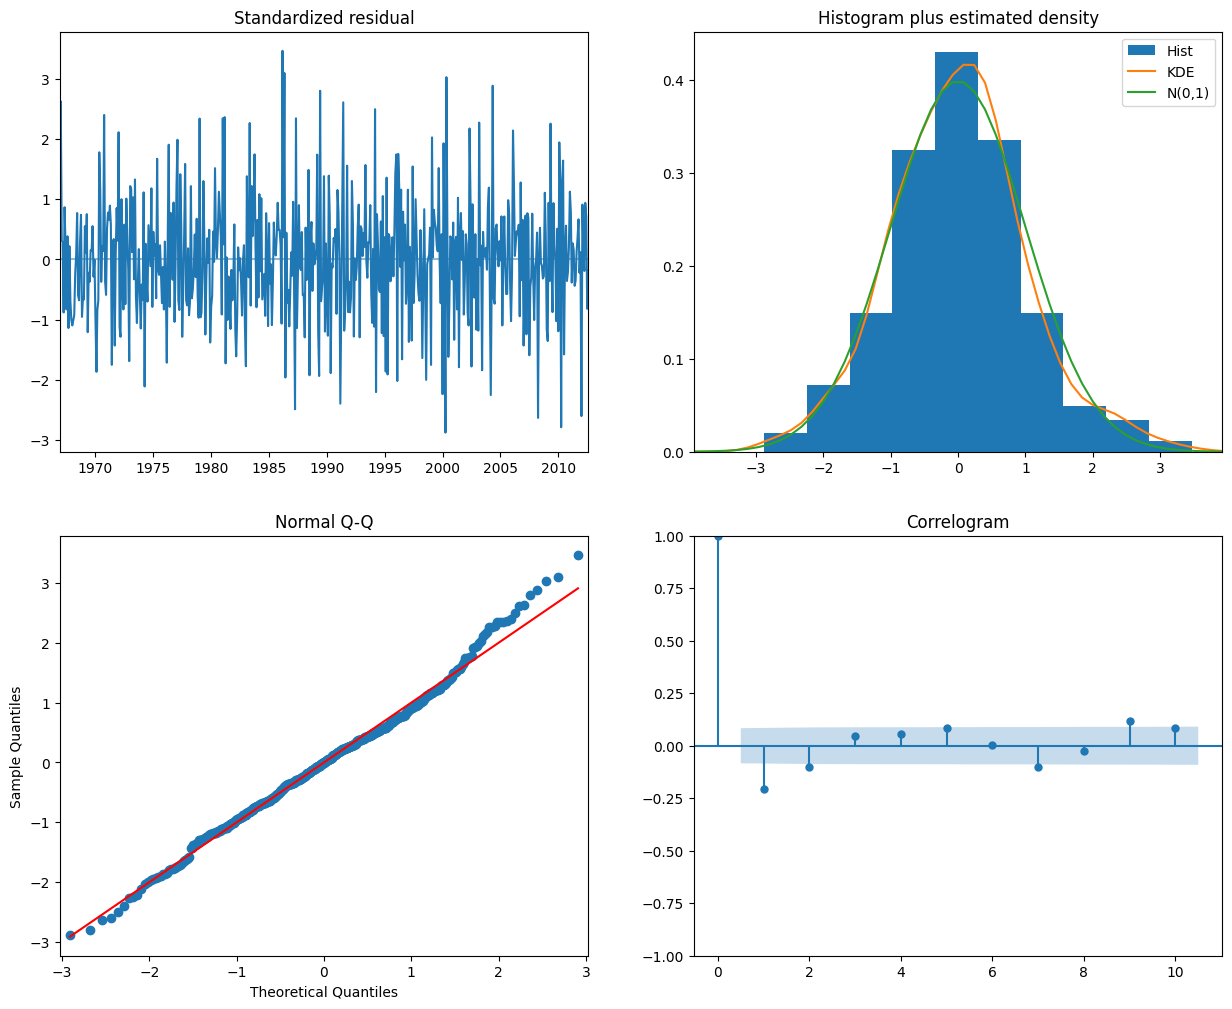

In [28]:
# RESIDUOS
ar_mod_f2.plot_diagnostics(figsize=(15,12))
plt.show()

Modelo Autoregressivo de Médias Móveis (ARMA)
Ferramenta estatístca avanaçada usada na análise de séries temporias que combias duas características principais: 
Autoregressiva(AR) e média movel(MA)

In [29]:
from statsmodels.tsa.arima.model import ARIMA

arma_mod = ARIMA(treino, order = (10,0,1)).fit()
print(arma_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                ARIMA(10, 0, 1)   Log Likelihood                -988.509
Date:                Fri, 12 Dec 2025   AIC                           2003.018
Time:                        06:55:10   BIC                           2059.257
Sample:                    02-01-1966   HQIC                          2024.979
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9727      0.008   2365.649      0.000      19.956      19.989
ar.L1         -0.0891      0.058     -1.544      0.123      -0.202       0.024
ar.L2         -0.3212      0.034     -9.505      0.0

c:\Users\init\Documents\GitHub\Estudos-praticos\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


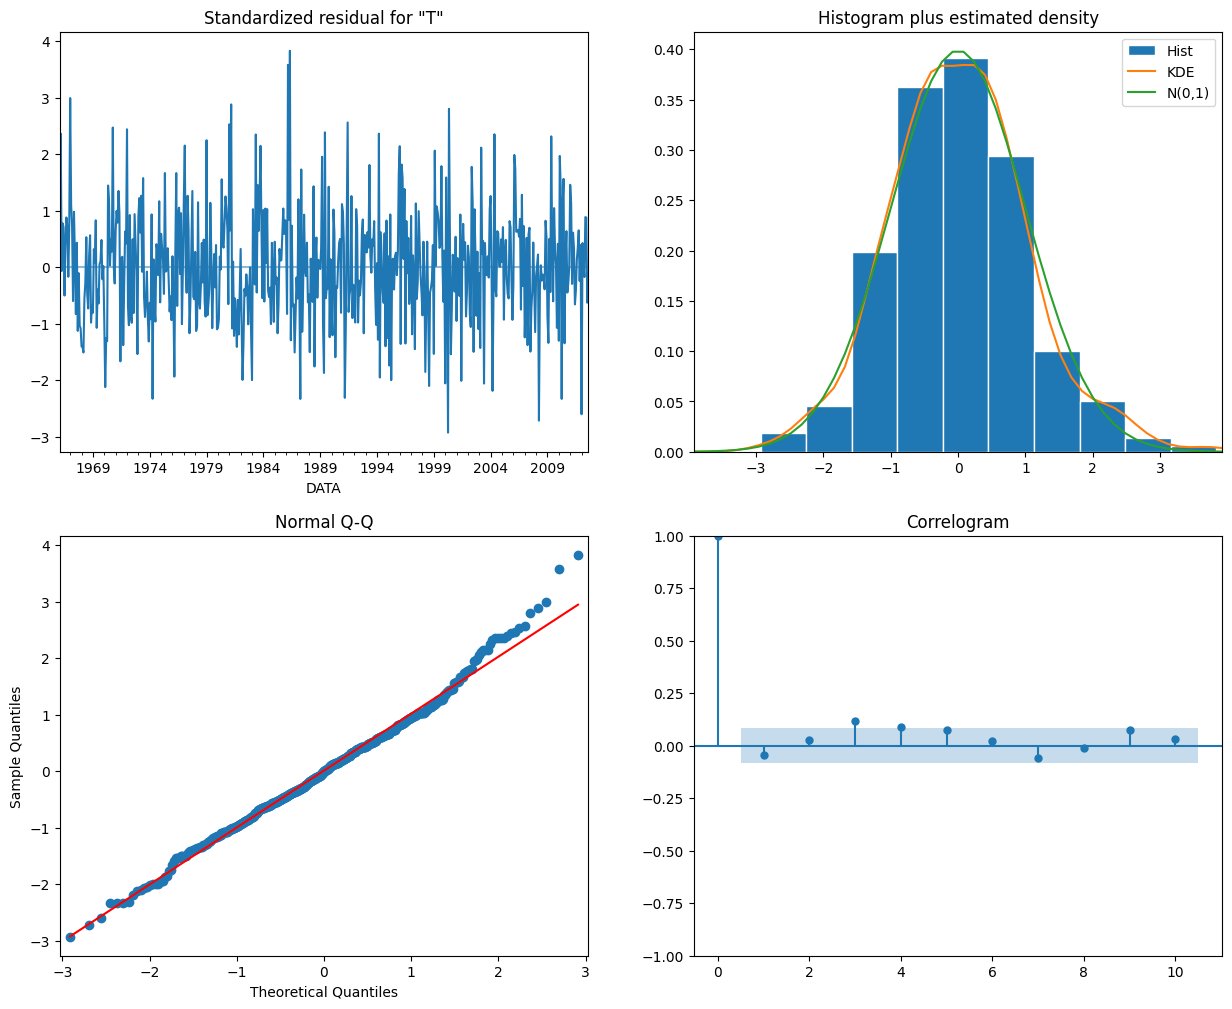

In [30]:
arma_mod.plot_diagnostics(figsize=(15,12))
plt.show()

# Com ARMA notamos uma sutil melhora em realção aos residuos em comparação com AR
# 1 Primeiro grafico mostra variação dentro de um intervalo de 4 a 4 anos o que sugere flutação constante aos longos dos anos.
# 2 Histogram com uma superposição de uma curva de estimativa de densidade KERNEL(kde) e uma curva normal teorioca, para verificar se seguem uma distribuição normal
# e com a maior parte dos dados concentrado no centro
# 3 QQ PLOT compara os quantis teóricos de uma distribuição normal com os quantis dos dados amostrais, destacando uma boa aderencia dos pontos á linha diagonal.
# sugerindo que os dados podem ser aproximadamente normais.
# 4 Correlograma, exibi as autocorrelações com diversas lags, com alguns valores oscilando proximos de 0. porem, notamos que alguns lags estavam fora do intervalo de confiança
#  

BUSCANDO O MELHOR PARAMETRO PARA ARMA

In [31]:
import itertools
import warnings
warnings.filterwarnings('ignore')

def grid_arima(p_inicial, p_final, q_inicial, q_final, d_valores, treino):
  # Definindo os parâmetros
  p_params = range(p_inicial, p_final)
  q_params = range(q_inicial, q_final)
  d_params = [d_valores]

  # Gerando todas as combinações possíveis usando product
  combinacoes = list(itertools.product(p_params, d_params, q_params))

  aic_grid = dict()
  # Treinando o modelo e salvando todas combinações
  for order in combinacoes:
    try:
      model = ARIMA(treino, order = order).fit()
      aic_grid[order] = list()
      aic_grid[order].append((model.aic if model.aic else float('inf')))
    except:
      continue
  return aic_grid, min(aic_grid, key=lambda x: aic_grid[x][0])

In [32]:
aic_arma = grid_arima(10, 25, 1, 3, 0, treino)

In [33]:
aic_arma[0]

{(10, 0, 1): [np.float64(2003.017505860685)],
 (10, 0, 2): [np.float64(1997.1503675219878)],
 (11, 0, 1): [np.float64(1965.5682070731416)],
 (11, 0, 2): [np.float64(1968.1620665199698)],
 (12, 0, 1): [np.float64(1966.8047015670973)],
 (12, 0, 2): [np.float64(1984.7801249669687)],
 (13, 0, 1): [np.float64(1966.8307789375917)],
 (13, 0, 2): [np.float64(1973.037481014072)],
 (14, 0, 1): [np.float64(1968.0463014079492)],
 (14, 0, 2): [np.float64(1970.5212326695496)],
 (15, 0, 1): [np.float64(2017.438685506897)],
 (15, 0, 2): [np.float64(1973.6454852464842)],
 (16, 0, 1): [np.float64(2023.3538490322117)],
 (16, 0, 2): [np.float64(1970.0210169124275)],
 (17, 0, 1): [np.float64(2024.4464665694081)],
 (17, 0, 2): [np.float64(1959.366498367484)],
 (18, 0, 1): [np.float64(2021.0023868377064)],
 (18, 0, 2): [np.float64(1961.0196307352644)],
 (19, 0, 1): [np.float64(2013.152704582154)],
 (19, 0, 2): [np.float64(1962.1525157804074)],
 (20, 0, 1): [np.float64(1971.181840562608)],
 (20, 0, 2): [np.fl

In [34]:
aic_arma[1]

(24, 0, 2)

In [36]:
arma_mod_ot = ARIMA(treino, order=aic_arma[1]).fit()
print(arma_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                ARIMA(24, 0, 2)   Log Likelihood                -934.111
Date:                Fri, 12 Dec 2025   AIC                           1924.221
Time:                        07:07:01   BIC                           2045.353
Sample:                    02-01-1966   HQIC                          1971.524
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9729      0.004   4631.010      0.000      19.964      19.981
ar.L1         -0.4115      0.318     -1.296      0.195      -1.034       0.211
ar.L2          0.1878      0.130      1.445      0.1

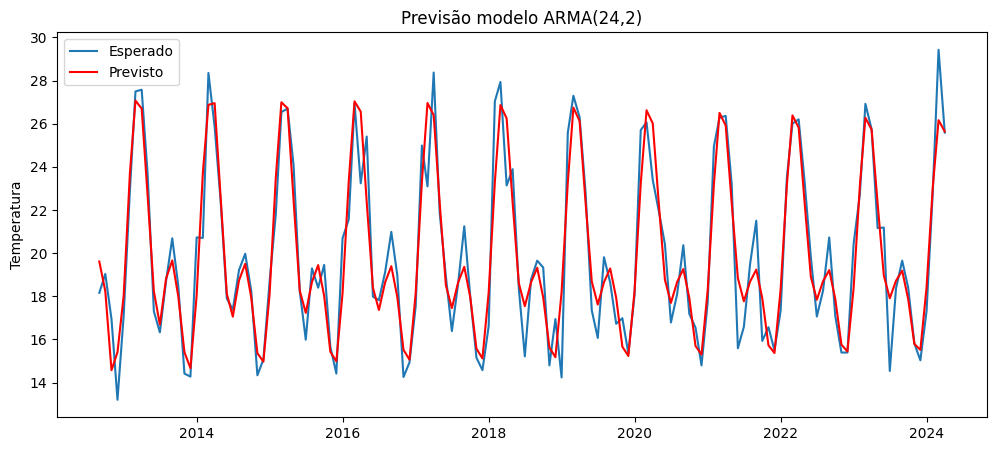


Métricas:

MAE: 1.0654564082666185
MSE: 1.980263571667632


In [37]:
plot_prev(treino, teste, arma_mod_ot, 'ARMA(24,2)')

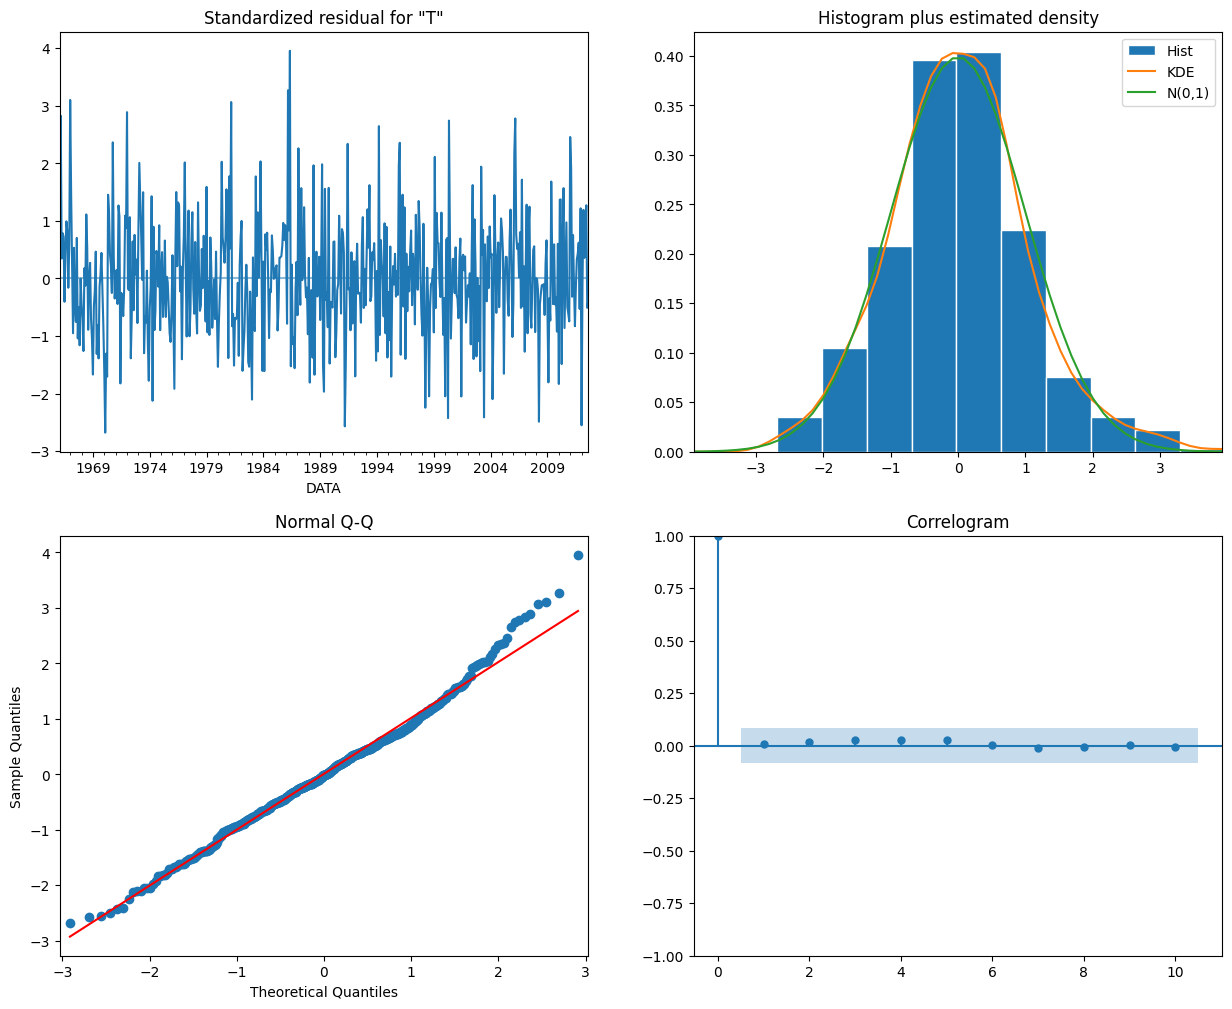

In [38]:
arma_mod_ot.plot_diagnostics(figsize=(15,12))
plt.show()